## Import Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import statsmodels as st
from scipy.stats import ttest_rel
#import arviz
#import pymc

c:\users\17083\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


In [2]:
pd.set_option("display.max_columns", None)

## Import Data

In [3]:
df_hitters = pd.read_csv("hitter_data.csv")
df_pitches = pd.read_csv("pitch_data.csv")

### Clean and Trim

In [4]:
df_hitters["batter_id"] = df_hitters["batter_id"].astype(str)
df_pitches["batter_id"] = df_pitches["batter_id"].astype(str)
df_pitches["pitcher_id"] = df_pitches["pitcher_id"].astype(str)
df_pitches["pitch_date"] = pd.to_datetime(df_pitches["pitch_date"])

### Filter base data - we only want to look at SWINGS here.

This is our first assumption. We will be testing this below.

In [5]:
df_main_blind = df_pitches[df_pitches["description"].isin(['In play, run(s)','In play, out(s)',
       'Swinging Strike', 'Foul', 'In play, no out',
       'Swinging Strike (Blocked)', 'Foul Tip'])]

## Create blind feature columns

In [6]:
### Contact - blind note: We want to track swing contact rates here. Therefore, bunts are not treated as contact swings.
df_main_blind["contact_blind"] = np.where(~df_main_blind["description"].isin(['Swinging Strike', 'Swinging Strike (Blocked)']),1,0)

<ipython-input-6-dca1a5c462f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_blind["contact_blind"] = np.where(~df_main_blind["description"].isin(['Swinging Strike', 'Swinging Strike (Blocked)']),1,0)


In [7]:
### 
df_main_blind = df_main_blind.merge(df_hitters, on="batter_id", how='inner')

## Check our blind assumptions distribution against 2023 data

### Why?
We don't know what the statisticians who came before us considered when they tracked contact rates. Therefore, it is good data governance practice to check our own assumptions against the data we have for last year before moving forward with modeling. To do this, we are going to use the entire YEAR of data for 2024, rather than just the data until June. This is okay to do because it is not a modeling practice, and in reality we should have the information on what is being considered as "contact" by the organization in a real business context.

### How?
We start by plotting our two distributions, one for the given contact rates of the previous year, and one for our own contact rate calculations.

Then we run a ***Paired t-test*** to see whether our distribution is *reasonably* similar to last year's, or whether we need to try again with our assumptions. We are using a paired test because each batter has two values: one for last year's contact rate and one for our contact rate calculation for the current year.


In [8]:
df_agg_test = (
    df_main_blind.groupby(['batter_id', 'contact_rate_2023'], as_index=False)
    .agg(contacts=('contact_blind', 'sum'), total=('contact_blind', 'count'))
)
df_agg_test['contact_rate_2024'] = df_agg_test['contacts'] / df_agg_test['total']

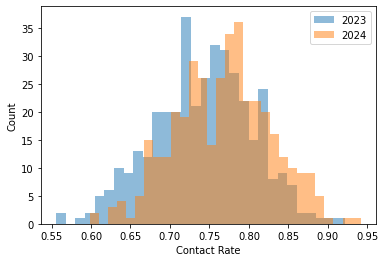

In [9]:
# plot distributions
plt.hist(df_agg_test['contact_rate_2023'], bins=30, alpha=0.5, label='2023')
plt.hist(df_agg_test['contact_rate_2024'], bins=30, alpha=0.5, label='2024')
plt.xlabel('Contact Rate')
plt.ylabel('Count')
plt.legend()
plt.show()

In [10]:
mask = df_agg_test['contact_rate_2023'].notna() & df_agg_test['contact_rate_2024'].notna()
t_stat, p_val = ttest_rel(df_agg_test.loc[mask, 'contact_rate_2023'], df_agg_test.loc[mask, 'contact_rate_2024'])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.5f}")

Paired t-test: t = -12.809, p = 0.00000


### Swing and a miss!

Our assumptions were *definitely* not the same as the Data Scientists of olde. After trying a few different iterations, we land on a suitable set of assumptions that pass our testing criteriae:

* We are only considering ***Swing Opportunities***
* We are including Bunt attempts as ***Swing Opportunities***
* Missed Bunts and Foul Bunts are contact fails. This makes sense because fouling a bunt off is never productive.

In [11]:
df_main = df_pitches

In [12]:
df_main["contact"] = np.where(df_pitches["description"].isin(['In play, out(s)', 'In play, run(s)', 'Foul', 'In play, no out', 'Bunt']),1,0)

In [13]:
df_main = df_main.merge(df_hitters, on="batter_id", how='inner')

In [14]:
df_valid = df_main[df_main["description"].isin(['In play, run(s)','In play, out(s)',
       'Swinging Strike', 'Foul', 'In play, no out',
       'Swinging Strike (Blocked)', 'Foul Tip', 'Missed Bunt', 'Bunt', 'Foul Bunt'])]

In [15]:
df_agg = (
    df_valid.groupby(['batter_id', 'contact_rate_2023'], as_index=False)
    .agg(contacts=('contact', 'sum'), total=('contact', 'count'))
)
df_agg['contact_rate_2024'] = df_agg['contacts'] / df_agg['total']

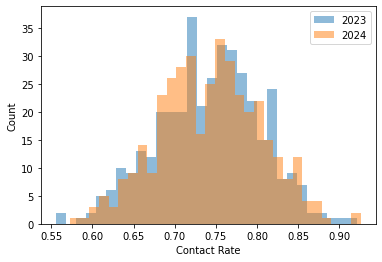

In [16]:
# plot distributions
plt.hist(df_agg['contact_rate_2023'], bins=30, alpha=0.5, label='2023')
plt.hist(df_agg['contact_rate_2024'], bins=30, alpha=0.5, label='2024')
plt.xlabel('Contact Rate')
plt.ylabel('Count')
plt.legend()
plt.show()

In [17]:
mask = df_agg['contact_rate_2023'].notna() & df_agg['contact_rate_2024'].notna()
t_stat, p_val = ttest_rel(df_agg.loc[mask, 'contact_rate_2023'], df_agg.loc[mask, 'contact_rate_2024'])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

Paired t-test: t = -0.561, p = 0.575


### There is no significant difference between these two distributions.

That means we can use the 2023 data as our modeling priors now, without making improper assumptions!

## Next, let's do a little more feature tuning

First, we calculate the columns that we can create before filtering down

In [18]:
league_contact_rate = df_main['contact_rate_2023'].mean(skipna=True)
league_logit = np.log(league_contact_rate / (1 - league_contact_rate))

df_main['logit_prev'] = np.where(
    df_main['contact_rate_2023'].notna(),
    np.log(df_main['contact_rate_2023'] / (1 - df_main['contact_rate_2023'])),
    league_logit
)

df_main['total_swings_2023'] = df_main['total_swings_2023'].fillna(0)

In [19]:
### Platoon Disadvantage - this will be a useful feature in our model (good for batters)
df_main['platoon_disadvantage'] = np.where(df_main['batter_stand'] != df_main['pitcher_throws'], 1,0)

In [20]:
### Batter Tenure - assumes rookies are in the data
df_main['batter_tenure'] = df_main['pro_debut_year'].max() - df_main['pro_debut_year']

In [21]:
### Batter Leverage Score - normalized.
df_main['batter_leverage'] = (
    2 * df_main['ball']       # reward high ball counts
    - 3 * df_main['strike']   # penalize strikes
    - 1 * df_main['out'])  # penalize outs

# Normalize 0–1 for interpretability
df_main['batter_leverage'] = (
    (df_main['batter_leverage'] - df_main['batter_leverage'].min()) /
    (df_main['batter_leverage'].max() - df_main['batter_leverage'].min())
)

In [22]:
# Adjusted plate location for handedness
df_main['plate_x_adj'] = np.where(
    df_main['batter_stand'] == 'L',
    -df_main['plate_x'],
    df_main['plate_x']
)

### Next, the ones *After* we filter to our date range.

These are going to include aggregate measures, rather than single-record granularity features.

In [23]:
df_filtered = df_main[df_main['pitch_date'] < pd.to_datetime('2024-07-01')]

In [24]:
# Swing Rate
swing_descriptions = [
    'Swinging Strike', 'Swinging Strike (Blocked)',
    'Foul', 'Foul Tip',
    'In play, no out', 'In play, run(s)', 'In play, out(s)'
]

df_filtered['is_swing'] = df_filtered['description'].isin(swing_descriptions)

swing_rate = (
    df_filtered.groupby('batter_id')['is_swing']
    .mean()
    .rename('swing_rate')
    .reset_index()
)


<ipython-input-24-ef674665716e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_swing'] = df_filtered['description'].isin(swing_descriptions)


In [25]:
# Chase rate
df_filtered['in_zone'] = (
    (df_filtered['plate_x'].between(-0.83, 0.83)) &  # roughly width of plate in ft
    (df_filtered['plate_z'] >= df_filtered['sz_bot']) &
    (df_filtered['plate_z'] <= df_filtered['sz_top'])
)

df_filtered['is_chase'] = df_filtered['is_swing'] & (~df_filtered['in_zone'])

chase_rate = (
    df_filtered.groupby('batter_id')['is_chase']
    .mean()
    .rename('chase_rate')
    .reset_index()
)

<ipython-input-25-555cf43d10c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['in_zone'] = (
<ipython-input-25-555cf43d10c8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_chase'] = df_filtered['is_swing'] & (~df_filtered['in_zone'])


In [26]:
# Zone contact & Outside contact

df_filtered['contact_in_zone'] = df_filtered['contact'] & df_filtered['in_zone']
df_filtered['contact_out_zone'] = df_filtered['contact'] & (~df_filtered['in_zone'])

z_contact = (
    df_filtered[df_filtered['in_zone']]
    .groupby('batter_id')
    .apply(lambda g: g['contact'].sum() / g['is_swing'].sum() if g['is_swing'].sum() > 0 else np.nan)
    .rename('z_contact_rate')
    .reset_index()
)

o_contact = (
    df_filtered[~df_filtered['in_zone']]
    .groupby('batter_id')
    .apply(lambda g: g['contact'].sum() / g['is_swing'].sum() if g['is_swing'].sum() > 0 else np.nan)
    .rename('o_contact_rate')
    .reset_index()
)


<ipython-input-26-d1fc556ad528>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['contact_in_zone'] = df_filtered['contact'] & df_filtered['in_zone']
<ipython-input-26-d1fc556ad528>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['contact_out_zone'] = df_filtered['contact'] & (~df_filtered['in_zone'])
<ipython-input-26-d1fc556ad528>:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping c

In [27]:
# Whiff rate by pitch
df_filtered['is_whiff'] = df_filtered['description'].isin(['Swinging Strike', 'Swinging Strike (Blocked)'])

whiff_by_pitch = (
    df_filtered[df_filtered['is_swing']]
    .groupby(['batter_id', 'pitch_type'])
    .apply(lambda g: g['is_whiff'].sum() / g['is_swing'].sum())
    .rename('whiff_rate')
    .reset_index()
)

<ipython-input-27-e3abcb4e76c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_whiff'] = df_filtered['description'].isin(['Swinging Strike', 'Swinging Strike (Blocked)'])
<ipython-input-27-e3abcb4e76c6>:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered[df_filtered['is_swing']]


In [28]:
# Average velocity faced
avg_velocity = (
    df_filtered.groupby('batter_id')['release_speed']
    .mean()
    .rename('avg_velocity_faced')
    .reset_index()
)

# per pitch type
avg_velocity_by_pitch = (
    df_filtered.groupby(['batter_id', 'pitch_type'])['release_speed']
    .mean()
    .rename('avg_velocity_by_pitch')
    .reset_index()
)

In [29]:
# Pitch mix
pitch_counts = (
    df_filtered.groupby(['batter_id', 'pitch_type'])
    .size()
    .rename('pitch_count')
    .reset_index()
)

pitch_counts['pitch_mix'] = (
    pitch_counts['pitch_count'] /
    pitch_counts.groupby('batter_id')['pitch_count'].transform('sum')
)

In [30]:
# Zone distribution faced

x_bins = [-np.inf, -0.83, 0.83, np.inf]
x_labels = ['Inside', 'Middle', 'Away']

z_bins = [0, 2.0, 3.5, np.inf]  # roughly low / mid / high strike zones
z_labels = ['Low', 'Middle', 'High']

df_filtered['zone_x_bin'] = pd.cut(df_filtered['plate_x_adj'], bins=x_bins, labels=x_labels)
df_filtered['zone_z_bin'] = pd.cut(df_filtered['plate_z'], bins=z_bins, labels=z_labels)

# Count pitches per zone combination
zone_counts = (
    df_filtered.groupby(['batter_id', 'zone_x_bin', 'zone_z_bin'])
    .size()
    .rename('pitch_count')
    .reset_index()
)

# Normalize within each batter (so sum = 1 per hitter)
zone_counts['zone_freq'] = (
    zone_counts['pitch_count'] /
    zone_counts.groupby('batter_id')['pitch_count'].transform('sum')
)


<ipython-input-30-1f96c8793583>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zone_x_bin'] = pd.cut(df_filtered['plate_x_adj'], bins=x_bins, labels=x_labels)
<ipython-input-30-1f96c8793583>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zone_z_bin'] = pd.cut(df_filtered['plate_z'], bins=z_bins, labels=z_labels)
<ipython-input-30-1f96c8793583>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

## Model: Bayesian Random-Walk

We will be using a dynamic Bayesian random-walk model with hierarchical pooling to attempt to predict a hitter's contact ability through the rest of the year using their contact ability through June. By using a random-walk, we are able to let a hitter's baseline contact ability drift over time in our model, accounting for hot and cold hitting streaks. 

Essentially, the model learns:
* each hitter’s baseline contact ability (which will vary week-to-week),
* how volatile their contact tends to be (how *much* it's expected to vary),
* how that ability changes over time,
* the quantified uncertainty around all of it.

Starting with our **Binomial distribution** (hitters will either make contact or won't make contact),
denoted ***y_it ~ Binomial(n_it, p_it)*** where 
* *y_it* = # contacts for hitter i in week t,
* *n_it* = # swings for hitter i in week t,
* and *p_it* = probability of contact for hitter i in week t,

We are able to say that each hitter has a probability of making contact ***p_it*** out of ***n_it*** swings.

Next, we define **Baseline Contact Ability** as the *log-odds* of a hitter's making contact over a given week as 
***logit(p_it)=θ_it+X_itβ*** where
* *X_it* = feature variables for hitter i in week t,
* *θ_it* = hitter i's baseline contact ability in week t.
* *β* = feature weights 

We're using log-odds here because it maps our probabilities, which are between 0 and 1, to unbounded simple linear dynamics, so that we can use Normal priors and noise variables while still mapping those results back to valid probabilities at the end. We are using a Gaussian random noise distribution, and we assume each hitter’s initial ability comes from a Normal distribution centered around their 2023 contact performance.

Our **Random Walk** formula is defined as: ***θ_it=θ_it−1+ε_it*** where 
* *θ_i0* = Normal distribution centered on last year's contact rate, modified by swing sample size. ***θ_i0∼Normal(logit(contact_rate_2023,i),1/sqrt(total_swings_2023,i))+c*** for hitter i,
* *ε_it* = hitter i's drift on a Normal distribution, or ***ε_it ~ Normal(0, 𝜎_rwi$^2$)*** where
* *𝜎_rw* = league-wide randomness factor. Future efforts could be to personalize these by player. We model this on a half normal distribution because it is used as a standard deviation and therefore cannot be negative. ***𝜎_rw ~ HalfNormal(0.5)***
* *c* = some constant to control effect of prior year sample size.

For rookies or players with no 2023 data, we assign a broader Normal prior centered on the league-average contact rate.
Note that hitter drift is not personalized in this model. This is an opportunity for future development!!!
